<hr style="border-width:2px;border-color:#75DFC1">
<h1 style = "text-align:center">Time Series Forecasting</h1>
<h2 style = "text-align:center">Univariate time series -  Study case - Stock market prediction </h2>

<h2 style = "text-align:center"> ARIMA with Grid Search walk-forward validation, Engle's ARCH test, LSTM Neural Network</h2>
<h4 style = "text-align:center">Didier Law-Hine</h4>
<h4 style = "text-align:center">July 2022</h4>

<hr style="border-width:2px;border-color:#75DFC1">

In this notebook, the dataset consists of records about the stock price of Tata Global Beverages Limited (https://data-flair.training/blogs/download-tata-global-beverages-stocks-data/). The dataset  contains a date-wise price of stock with Open, Close, High, and Low prices along with volume quantity traded as well as turnover on that day. We will focus only on the variable 'Close' and consider an **univariate time series**.

**Topics tackled** in this notebook:
 - Handling missing values (missing days). Our initial time series dataset is not a proper time series and pre-processing is needed. 
**Resampling** daily, filling NaNs, **resampling** again weekly instead of daily for more simplicity (we note that overall shape is maintained). **Interpolation** might be required.
 
 
 - **Stationarity**, plotting **autocorrelations**, **Augmented Dickey-Fuller (ADF) and KPSS statistic tests**.  This notebook contains some code lines from https://towardsdatascience.com/multi-step-time-series-forecasting-with-arima-lightgbm-and-prophet-cc9e3f95dfb0


 - **Grid Search ARIMA** with **Walk-Forward Validation** (**GD-ARIMA-WFV**) where the model is updated each time step new data is received. This notebook is inspired from the implementation of such model that can be found here: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/. 
 
 
 - **Engle’s ARCH statistic test**. The time series could not be well modelled with ARIMA as the presence of ARCH effects was detected. Volatility in stock price evolution is a known process in such time series which renders difficult the modeling with simple ARIMA model. I tried to model with GARCH but I found out that a statistical software is capable of doing that in R langage (see e.g. rugarch package for R), but does not exist in Python.
 
 
 - **LSTM Neural Network** (also inspired from machinelearningmastery) in which we consider the following important parameters to be tuned :
- the **number of lag $n$** (here $n$ = $n$_ $weeks$) to account for the prediction of  $y_t$ :  $y_{t-1},y_{t-2}, ... , y_{t-n}$. In this notebook, $n$_ $weeks$=8 is the reference. I will then tune to $n$_ $weeks$=4,12,16 to check if any improvement is observed.
- Architecture with number of **hidden layers** and **units** in each layer. Here, I chose 1 layer of 50 units as my reference. I then tuned the number of layers to 2 and 3. Then, I tuned the number of units to 200.
- **epochs** and **batch size**. Here, epochs=150 and batch size=20 are the reference.


 - **Data Splitting**. Splitting in **GD-ARIMA-WFV**: Train + Test splitting (70%/15%; remaining 15% is untouched). Splitting in **LSTM**: Train + Test + Forecast splitting (70%/15%/15%).  We use the Train+Test samples identical in each method.
 
 
Topics not discussed but that can be implemented:
 - **Multiple Train-Test Splits**. Repeat the process of splitting into train and test sets in multiple ways. More computationally expensive but probably more robust.

 - **Multi-step prediction**. Predict $n$ simultaneous values  yhat(t),yhat(t+1),...,yhat(t+n) at one step. Computation of RMSE would not be straightforward though.

 - **Other Metrics**. Root mean squared error (RMSE) is being used here and comparison between ARIMA and LSTM is made on same validation sample. Other statistics such as MAPE (Mean Absolute Percentage Error), AIC, BIC should be explored.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12,7

from math import sqrt
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.graphics.tsaplots as smgt

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from pmdarima.arima import auto_arima

import arch

import datetime as dt

import warnings

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1235 non-null   datetime64[ns]
 1   Open                  1235 non-null   float64       
 2   High                  1235 non-null   float64       
 3   Low                   1235 non-null   float64       
 4   Last                  1235 non-null   float64       
 5   Close                 1235 non-null   float64       
 6   Total Trade Quantity  1235 non-null   float64       
 7   Turnover (Lacs)       1235 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 77.3 KB


None

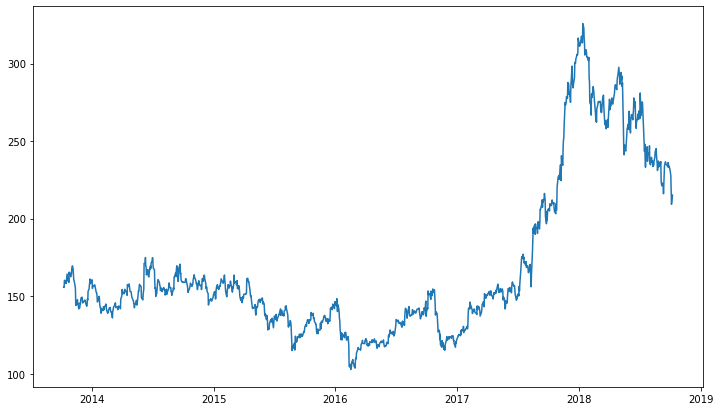

In [2]:
# Load dataset
df = pd.read_csv("NSE-Tata-Global-Beverages-Limited.csv")
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
display(df.head())
display(df.info())
# Dataviz
fig,ax1=plt.subplots()
ax1=plt.plot(df["Date"],df["Close"],label='Close Price history')

,Close
Date,
2013-10-08,155.8
2013-10-09,155.55
2013-10-10,160.15
2013-10-11,160.05
2013-10-12,NaN


(1827, 1)

,Close
Date,
2013-10-13,157.887500
2013-10-20,160.925000
2013-10-27,161.900000
2013-11-03,165.308333
2013-11-10,162.900000


(262, 1)

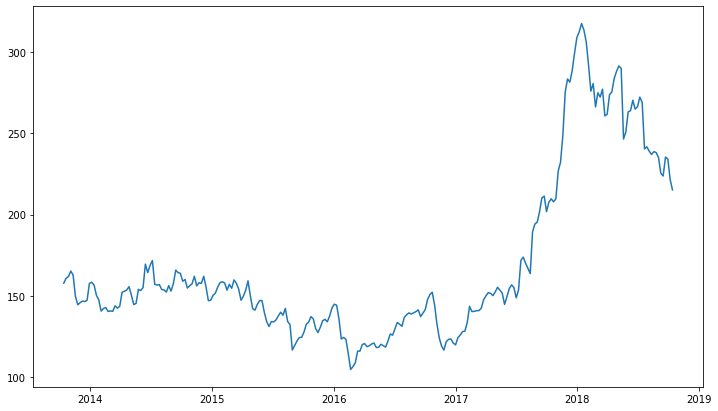

In [3]:
# Selecting the time series from the initial dataset, sorting in ascending order of date
df2=df.sort_values(by=["Date"],ascending=True,axis=0).reset_index(drop=True)
df3=pd.DataFrame(index=range(0,len(df2)),columns=['Date','Close'])
for i in range(0,len(df3)):
    df3["Date"][i]=df2['Date'][i]
    df3["Close"][i]=df2["Close"][i]   
df3.index=df3.Date
df3.drop("Date",axis=1,inplace=True)
# Handling missing values (missing dates... the time seres is not a time series...). Resampling
df3=df3.asfreq(freq='D') # This will add rows so that frequency is equal to 1 day. But this will generate NaNs
display(df3.head(), df3.shape)
# Resample Data to Weekly instead of Daily by Aggregating Using Mean
df3= df3.resample('W').mean()
display(df3.head(), df3.shape)
plt.plot(df3,label='Weekly Averages Stock')
plt.show()
# 'resample' method fills Nans values, unlike 'asfreq'. Otherwise we use the following to fill NaNs with interpolating
#https://towardsdatascience.com/4-techniques-to-handle-missing-values-in-time-series-data-c3568589b5a8
#df3=df3.astype('float')
#df3['Close'].interpolate(inplace=True,limit_direction='forward', axis=0) #default is linear interpolating
#display(df3.head(10))
#display(df3.shape)

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> Time Series analysis: stationnarity, autocorrelations, statistic tests </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

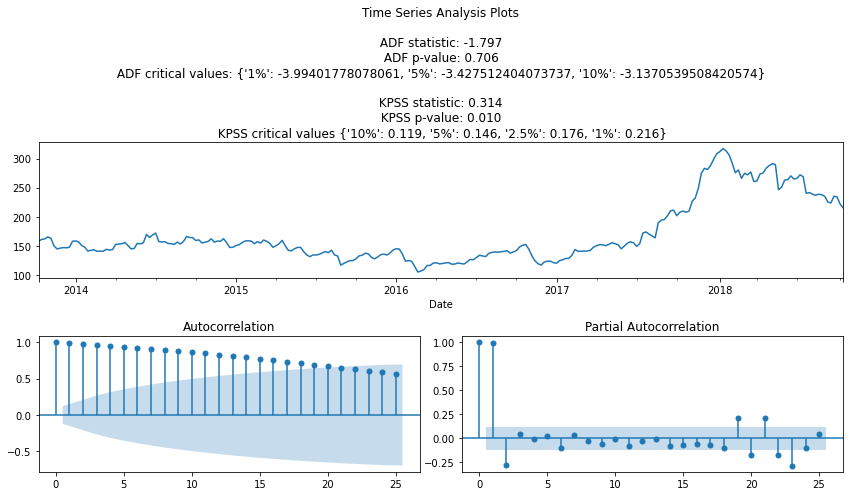

In [4]:
def tsplot(y, lags=None, figsize=(12, 7)):   
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ADF_statistic, KPSS_statistic=sm.tsa.stattools.adfuller(y,regression='ct')[0], sm.tsa.stattools.kpss(y,regression='ct')[0]
    ADF_pvalue , KPSS_pvalue = sm.tsa.stattools.adfuller(y,regression='ct')[1], sm.tsa.stattools.kpss(y,regression='ct')[1]
    ADF_critvalues , KPSS_critvalues = sm.tsa.stattools.adfuller(y,regression='ct')[4], sm.tsa.stattools.kpss(y,regression='ct')[3]
    ts_ax.set_title('Time Series Analysis Plots\n \n ADF statistic: {0:.3f} \n ADF p-value: {1:.3f} \n ADF critical values: {2:} \n \n KPSS statistic: {3:.3f} \n KPSS p-value: {4:.3f} \n KPSS critical values {5:}'.format(ADF_statistic,ADF_pvalue,ADF_critvalues,KPSS_statistic,KPSS_pvalue,KPSS_critvalues))
    #ts_ax.set_title('Time Series Analysis Plots\n \n ADF p-value: {0:.3f} \n ADF critical values: {1:} \n \n KPSS p-value: {2:.3f} \n KPSS critical values {3:}'.format(ADF_pvalue,ADF_critvalues,KPSS_pvalue,KPSS_critvalues))
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
# Plot the series
warnings.filterwarnings("ignore")
tsplot(df3['Close'])

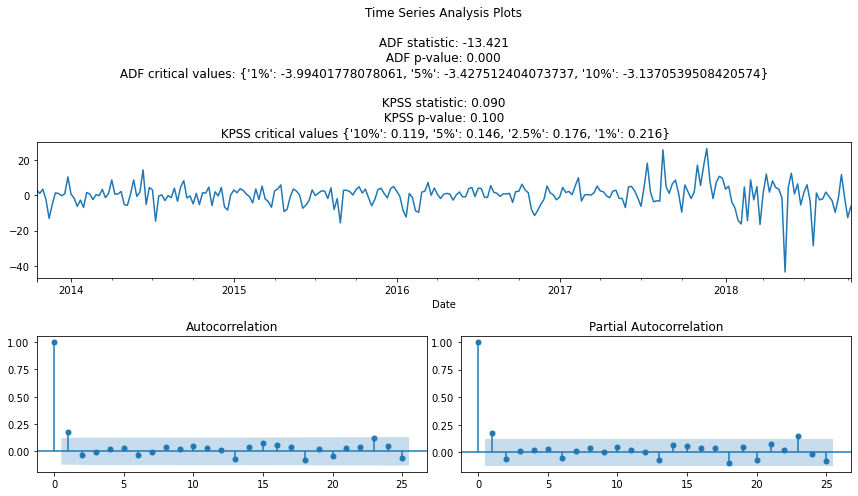

In [5]:
# Plot the series (differenced order 1)
ts_diff = df3["Close"].diff(1).dropna() 
warnings.filterwarnings("ignore")
tsplot(ts_diff)

> The statistic tests figure out if the time series is stationary around a constant or a constant and trend, or is non-stationary due to a unit root. We indeed  considered the two options regression='c' and regression='ct' that gave similar results.
>
> The **null hypothesis** of the **Augmented Dickey-Fuller (ADF)** is that there is a unit root with the **alternative** that there is no unit root. If the p-value is above a critical size, then we cannot reject that there is a unit root and we shall consider the series not stationary.
>
> The **null hypothesis** for the **Kwiatkowski–Phillips–Schmidt–Shin (KPSS)** test is that the data is stationary.
The **alternate hypothesis** for the test is that the data is not stationary.
>
> https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
>
> https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/#:~:text=KPSS%20test%20is%20a%20statistical,function%20and%20in%20practical%20usage.
>
> The original time series is clearly not stationnary.
>
> The differenciated series (order 1) yields ADF p-value=0.000 and KPSS p-value= 0.10 that both indicate non stationnarity.
Though they are both on on the boundary limit, I choose to continue with the differenciated series. Note that variability can be observed in the differenced series that suggest ARCH effects. This will be discussed in next section.

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> ARIMA with Grid search walk-forward validation , ARCH effects</h2> 
<hr style="border-width:2px;border-color:#75DFC1">

In [6]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model_test(train,test,forecast, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.SARIMAX(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse,train,test,predictions,model_fit
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_test(train,test,forecast, p_values, d_values, q_values):
    train,test,forecast = train.astype('float32'),test.astype('float32'),forecast.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse,train,test,predictions,model_fit = evaluate_arima_model_test(train,test,forecast, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# prepare train,test,forecast from dataset
dataset=df3.Close.values # Pay attention to df.ColumnName.values
train_size = int(len(dataset) * 0.7)
test_size = int(len(dataset) * 0.15)
train, test ,forecast = dataset[0:train_size], dataset[train_size:train_size+test_size], dataset[train_size+test_size:]
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(1, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models_test(train,test,forecast, p_values, d_values, q_values) 

ARIMA(0, 1, 0) RMSE=8.936
ARIMA(0, 1, 1) RMSE=8.340
ARIMA(0, 1, 2) RMSE=8.372
ARIMA(1, 1, 0) RMSE=8.368
ARIMA(1, 1, 1) RMSE=8.353
ARIMA(1, 1, 2) RMSE=8.509
ARIMA(2, 1, 0) RMSE=8.397
ARIMA(2, 1, 1) RMSE=8.645
ARIMA(2, 1, 2) RMSE=8.742
Best ARIMA(0, 1, 1) RMSE=8.340


Best RMSE: 8.340


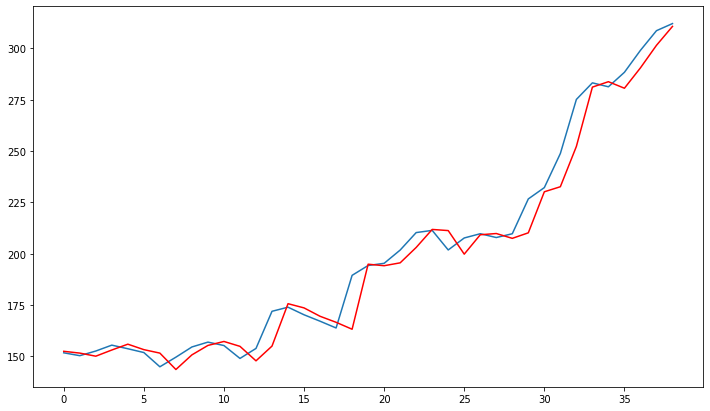

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  221
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -680.847
Date:                Fri, 02 Sep 2022   AIC                           1365.695
Time:                        14:52:21   BIC                           1372.482
Sample:                             0   HQIC                          1368.436
                                - 221                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2949      0.054      5.503      0.000       0.190       0.400
sigma2        28.5376      1.639     17.409      0.000      25.325      31.751
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               148.80
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             0.70
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

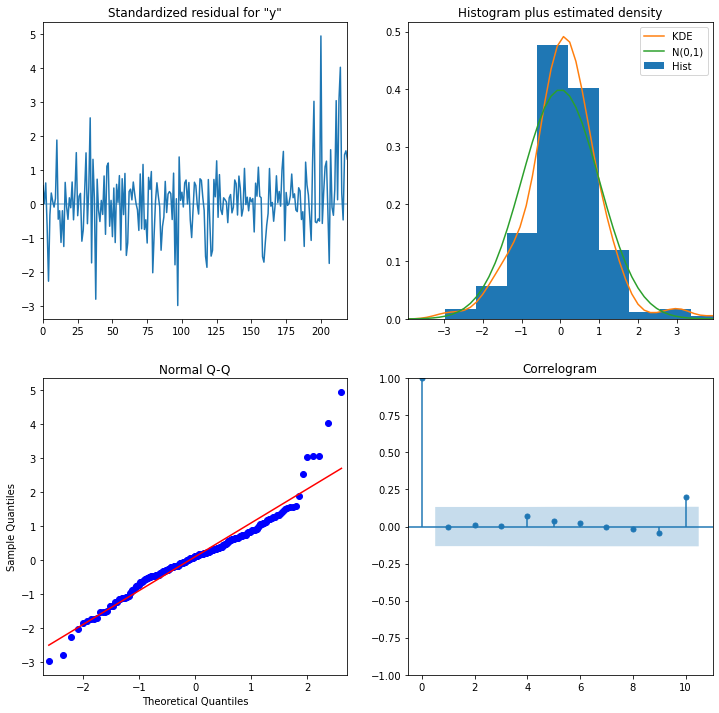

In [7]:
# Evaluate with best parameters
rmse,train,test,predictions,model_fit = evaluate_arima_model_test(train,test,forecast, (0, 1, 1))
print('Best RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
display(model_fit.summary())
##Checking Model Diagnotics on Training Data
model_fit.plot_diagnostics(figsize=(12, 12))
plt.show()

In [8]:
print(len(train))
print(train)

183
[157.8875     160.925      161.9        165.30833333 162.9
 149.8375     144.61       145.9        146.9        146.61
 147.4        157.7625     158.41       156.72       150.45
 147.69       140.78       142.28       142.96       140.51
 140.85       140.62       143.97       142.58       143.66
 152.31       152.925      153.66666667 155.7625     150.4875
 144.77       145.44       154.07       153.42       155.19
 169.55       164.37       168.73       171.79       157.19
 156.75       156.95       153.975      153.8        152.4
 156.39       153.         157.6        165.86       164.34
 163.95       159.06666667 160.1375     154.9        156.275
 157.5        162.1        156.26       158.17       157.75
 162.13       155.55       147.15       147.3875     150.37
 151.77       155.48       158.18       158.775      157.95
 153.61       157.175      154.75       159.8875     157.8
 154.22       147.44       149.88333333 153.48       159.325
 150.11       142.1875     141.34  

In [9]:
print(len(test))
print(test)

39
[151.65   150.25   152.52   155.3875 153.63   151.78   144.84   149.52
 154.5    156.86   155.19   148.9125 153.78   171.88   173.88   170.18
 167.05   163.75   189.4    194.2    195.26   201.72   210.24   211.31
 201.77   207.6125 209.68   207.825  209.67   226.64   232.16   248.77
 275.12   283.21   281.28   288.35   299.05   308.625  312.09  ]


In [10]:
# Engle’s Test for Autoregressive Conditional Heteroscedasticity (ARCH) - ARCH-LM test
arima_residuals = model_fit.resid
sm.stats.diagnostic.het_arch(arima_residuals, nlags=None, store=False, ddof=0)

(44.35383928774254,
 9.677856346058067e-05,
 3.4755870177752817,
 2.9480984703127237e-05)

> - The Q-Q plot shows an asymmetrical view of the distribution tails; the distribution’s left and right tails (i.e. extreme negative and positive returns) are far more deviant from what the Gaussian distribution suggests (the skew is not zero but very close and kurtosis not 3 and very far, which are values expected for Normal distribution). This is a well-documented phenomenon in the financial time series.
>
>
> - ARCH Lagrange Multiplier (ARCH-LM) test is a test used to test for ARCH effects by regressing the squared errors on its lags. The null hypothesis is that the lagged regression coefficients are zero there are no ARCH effects.
>
> https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff
> https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_arch.html#statsmodels.stats.diagnostic.het_arch
>
> Low p-values indicate the null hypothesis must be rejected. Hence, it is highly suggested the presence of ARCH effects. Our time series cannot be modelled properly with simple ARIMA methods since the ARIMA residuals are not white noise but still contain information.
>
>
> - The Ljung-Box is a statistical test based on autocorrelations. The null hypothesis is H0: The data are independently distributed. 
> Although the Ljung-Box p-value is high, which point forwards au Gaussian white noise, the residuals are not white noise. 
> Ljung-Box test assumes conditional homoskedasticity. Conditional heteroskedasticity of ARMA model residuals is detected with ARCH test. Ljung-Box test results can not be trusted.
https://stats.stackexchange.com/questions/77925/procedure-for-fitting-an-arma-garch-model
>
>
> -  Jarque-Bera tests if the distribution follows a normal distribution. Null hypothesis H0 is data follows normal distribution. p-value is zero, and hence we reject H0.

In [11]:
#train_size = int(len(df3.Close.values) * 0.7)
#lasttime_in_train=df3.Close.index[train_size].to_pydatetime()
#lasttime_in_train=np.datetime64(lasttime_in_train)
#lasttime_in_train
## fit a GARCH(1,1) model on the residuals of the ARIMA model
#garch = arch.arch_model(arima_residuals, p=1, q=1)
#split_date = dt.datetime(2017,4,16)
#garch_fitted = garch.fit()
#print(garch_fitted.summary())

<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> LSTM Neural Network </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

In [12]:
# Preparing data for LSTM
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Selecting the time series from the initial dataframe --> called 'values' (np.array)
values=df3.values
display(values.shape)
## integer encode direction
##encoder = LabelEncoder()
##values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_weeks = 8
n_features = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_weeks, 1)
print(reframed.head())
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_weeks = int(len(values) * 0.7)
n_test_weeks = int(len(values) * 0.15)
train = values[:n_train_weeks, :]
test = values[n_train_weeks:n_train_weeks+n_test_weeks, :]
forecast = values[n_train_weeks+n_test_weeks:, :]
# split into input and outputs
n_obs = n_weeks * n_features
X_train, y_train = train[:, :n_obs], train[:, -n_features]
X_test, y_test = test[:, :n_obs], test[:, -n_features]
X_forecast, y_forecast = forecast[:, :n_obs], forecast[:, -n_features]
print(X_train.shape, y_train.shape)
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_weeks, n_features))
X_test = X_test.reshape((X_test.shape[0], n_weeks, n_features))
X_forecast = X_forecast.reshape((X_forecast.shape[0], n_weeks, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,X_forecast.shape,y_forecast.shape)

(262, 1)

    var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
8    0.249576   0.263883   0.268475   0.284529   0.273185   0.211660   
9    0.263883   0.268475   0.284529   0.273185   0.211660   0.187038   
10   0.268475   0.284529   0.273185   0.211660   0.187038   0.193114   
11   0.284529   0.273185   0.211660   0.187038   0.193114   0.197824   
12   0.273185   0.211660   0.187038   0.193114   0.197824   0.196458   

    var1(t-2)  var1(t-1)   var1(t)  
8    0.187038   0.193114  0.197824  
9    0.193114   0.197824  0.196458  
10   0.197824   0.196458  0.200179  
11   0.196458   0.200179  0.248987  
12   0.200179   0.248987  0.252037  
(254, 9)
(177, 8) (177,)
(177, 8, 1) (177,) (38, 8, 1) (38,) (39, 8, 1) (39,)


> In the following, we will derive 4 models, varying the number of layers and units

> Model 1 : 1 LSTM layer (50 units), 1 Dense layer (1 unit)

2022-09-02 14:52:22.381192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/150
9/9 [==============================] - 3s 67ms/step - loss: 0.0239 - val_loss: 0.1460
Epoch 2/150
9/9 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0609
Epoch 3/150
9/9 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0596
Epoch 4/150
9/9 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0783
Epoch 5/150
9/9 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0766
Epoch 6/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0635
Epoch 7/150
9/9 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0561
Epoch 8/150
9/9 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0548
Epoch 9/150
9/9 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0519
Epoch 10/150
9/9 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0465
Epoch 11/150
9/9 [=====

9/9 [==============================] - 0s 8ms/step - loss: 9.6061e-04 - val_loss: 0.0061
Epoch 85/150
9/9 [==============================] - 0s 13ms/step - loss: 9.5420e-04 - val_loss: 0.0061
Epoch 86/150
9/9 [==============================] - 0s 8ms/step - loss: 9.4788e-04 - val_loss: 0.0060
Epoch 87/150
9/9 [==============================] - 0s 9ms/step - loss: 9.4165e-04 - val_loss: 0.0059
Epoch 88/150
9/9 [==============================] - 0s 8ms/step - loss: 9.3551e-04 - val_loss: 0.0058
Epoch 89/150
9/9 [==============================] - 0s 8ms/step - loss: 9.2945e-04 - val_loss: 0.0057
Epoch 90/150
9/9 [==============================] - 0s 8ms/step - loss: 9.2349e-04 - val_loss: 0.0056
Epoch 91/150
9/9 [==============================] - 0s 8ms/step - loss: 9.1761e-04 - val_loss: 0.0056
Epoch 92/150
9/9 [==============================] - 0s 8ms/step - loss: 9.1183e-04 - val_loss: 0.0055
Epoch 93/150
9/9 [==============================] - 0s 8ms/step - loss: 9.0614e-04 - val_loss:

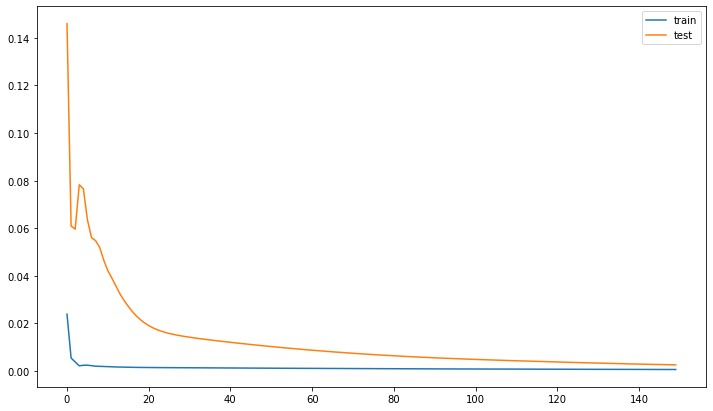

In [13]:
# Model 1 : LSTM(50),Dense(1)
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=150, batch_size=20, validation_data=(X_test, y_test), verbose=1, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

2/2 [==============================] - 0s 4ms/step
Test RMSE: 10.850
Forecast RMSE: 14.161


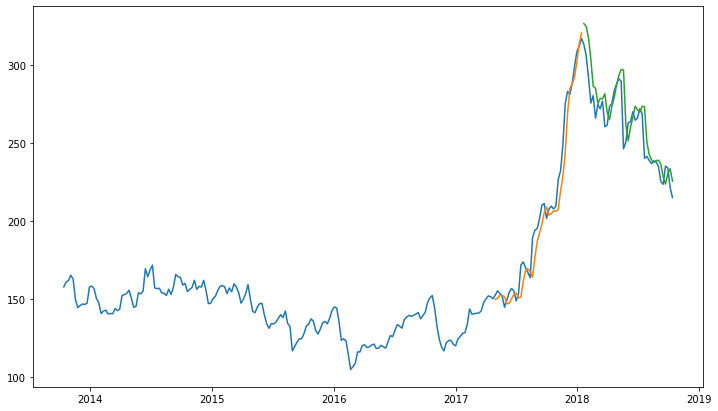

In [14]:
# Make a prediction for validation and forecasting
yhat_test = model.predict(X_test)
X_test2 = X_test.reshape((X_test.shape[0], X_test.shape[1]))
yhat_forecast = model.predict(X_forecast)
X_forecast2 = X_forecast.reshape((X_forecast.shape[0], X_forecast.shape[1]))
# invert scaling 
inv_yhat_test = concatenate((yhat_test, X_test2[:, - n_features -1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
inv_yhat_forecast = concatenate((yhat_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_yhat_forecast = scaler.inverse_transform(inv_yhat_forecast)
inv_yhat_forecast = inv_yhat_forecast[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_test = concatenate((y_test, X_test2[:, - n_features -1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]
y_forecast = y_forecast.reshape((len(y_forecast), 1))
inv_y_forecast = concatenate((y_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_y_forecast = scaler.inverse_transform(inv_y_forecast)
inv_y_forecast = inv_y_forecast[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_forecast, inv_yhat_forecast))
print('Forecast RMSE: %.3f' % rmse)
# Plot prediction
df_values=df3.Close
d = {'train': df_values,
     'test': pd.Series(inv_yhat_test, index=df_values.index[np.arange(n_train_weeks+n_weeks,n_train_weeks+n_test_weeks+n_weeks)]),
     'forecast': pd.Series(inv_yhat_forecast, index=df_values.index[np.arange(n_train_weeks+n_test_weeks+n_weeks,len(values)+n_weeks)])
                           }
df_plot=pd.DataFrame(data=d, index=df3.index)
plt.figure();
plt.plot(df_plot);


In [15]:
print(len(inv_y_test))
print(inv_y_test)

38
[152.52   155.3875 153.63   151.78   144.84   149.52   154.5    156.86
 155.19   148.9125 153.78   171.88   173.88   170.18   167.05   163.75
 189.4    194.2    195.26   201.72   210.24   211.31   201.77   207.6125
 209.68   207.825  209.67   226.64   232.16   248.77   275.12   283.21
 281.28   288.35   299.05   308.625  312.09   317.21  ]


> Model 2 : 2 LSTM layers (2 x 50 units), 1 Dense layer (1 unit)

Epoch 1/150
9/9 [==============================] - 5s 110ms/step - loss: 0.0198 - val_loss: 0.0822
Epoch 2/150
9/9 [==============================] - 0s 13ms/step - loss: 0.0052 - val_loss: 0.0533
Epoch 3/150
9/9 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0870
Epoch 4/150
9/9 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0679
Epoch 5/150
9/9 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0508
Epoch 6/150
9/9 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 0.0550
Epoch 7/150
9/9 [==============================] - 0s 18ms/step - loss: 0.0020 - val_loss: 0.0476
Epoch 8/150
9/9 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 0.0387
Epoch 9/150
9/9 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0362
Epoch 10/150
9/9 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0303
Epoch 11/150
9/9 [

9/9 [==============================] - 0s 14ms/step - loss: 8.7616e-04 - val_loss: 0.0032
Epoch 84/150
9/9 [==============================] - 0s 15ms/step - loss: 8.6721e-04 - val_loss: 0.0031
Epoch 85/150
9/9 [==============================] - 0s 15ms/step - loss: 8.5826e-04 - val_loss: 0.0031
Epoch 86/150
9/9 [==============================] - 0s 14ms/step - loss: 8.4931e-04 - val_loss: 0.0030
Epoch 87/150
9/9 [==============================] - 0s 13ms/step - loss: 8.4037e-04 - val_loss: 0.0030
Epoch 88/150
9/9 [==============================] - 0s 14ms/step - loss: 8.3144e-04 - val_loss: 0.0030
Epoch 89/150
9/9 [==============================] - 0s 13ms/step - loss: 8.2250e-04 - val_loss: 0.0029
Epoch 90/150
9/9 [==============================] - 0s 17ms/step - loss: 8.1357e-04 - val_loss: 0.0029
Epoch 91/150
9/9 [==============================] - 0s 12ms/step - loss: 8.0464e-04 - val_loss: 0.0029
Epoch 92/150
9/9 [==============================] - 0s 15ms/step - loss: 7.9572e-04 - 

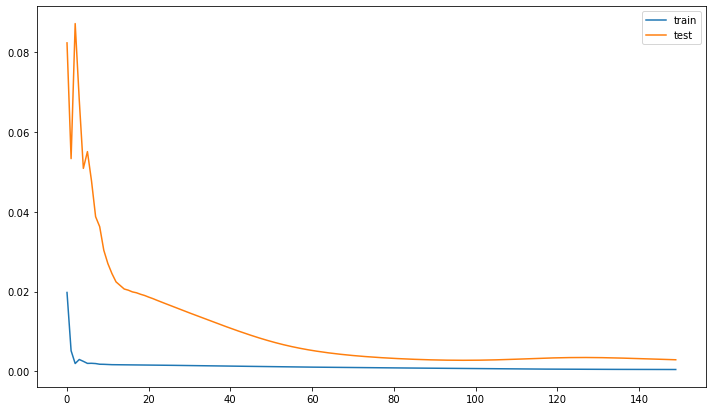

In [16]:
# Model 2 : LSTM(50),LSTM(50),Dense(1)
# design network
model2 = Sequential()
model2.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(loss='mse', optimizer='adam')
# fit network
history2 = model2.fit(X_train, y_train, epochs=150, batch_size=20, validation_data=(X_test, y_test), verbose=1, shuffle=False)
# plot history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step
Test RMSE: 11.489
Forecast RMSE: 37.209


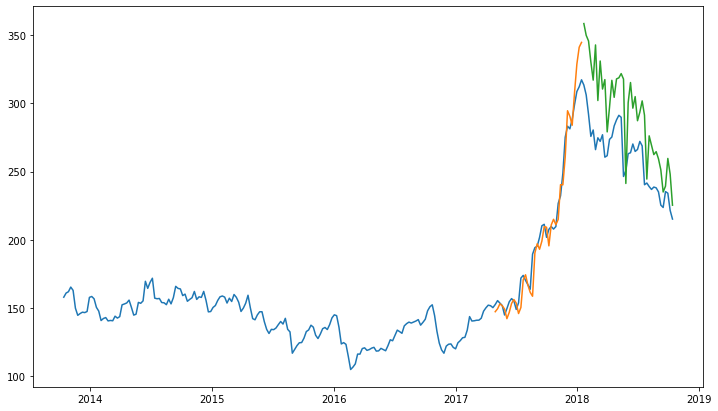

In [17]:
# Make a prediction for validation and forecasting
yhat_test = model2.predict(X_test)
X_test2 = X_test.reshape((X_test.shape[0], X_test.shape[1]))
yhat_forecast = model2.predict(X_forecast)
X_forecast2 = X_forecast.reshape((X_forecast.shape[0], X_forecast.shape[1]))
# invert scaling 
inv_yhat_test = concatenate((yhat_test, X_test2[:, - n_features -1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
inv_yhat_forecast = concatenate((yhat_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_yhat_forecast = scaler.inverse_transform(inv_yhat_forecast)
inv_yhat_forecast = inv_yhat_forecast[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_test = concatenate((y_test, X_test2[:, - n_features -1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]
y_forecast = y_forecast.reshape((len(y_forecast), 1))
inv_y_forecast = concatenate((y_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_y_forecast = scaler.inverse_transform(inv_y_forecast)
inv_y_forecast = inv_y_forecast[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_forecast, inv_yhat_forecast))
print('Forecast RMSE: %.3f' % rmse)
# Plot prediction
df_values=df3.Close
d = {'train': df_values,
     'test': pd.Series(inv_yhat_test, index=df_values.index[np.arange(n_train_weeks+n_weeks,n_train_weeks+n_test_weeks+n_weeks)]),
     'forecast': pd.Series(inv_yhat_forecast, index=df_values.index[np.arange(n_train_weeks+n_test_weeks+n_weeks,len(values)+n_weeks)])
                           }
df_plot=pd.DataFrame(data=d, index=df3.index)
plt.figure();
plt.plot(df_plot);


> Model 3 : 3 LSTM layers (3 x 50 units), 1 Dense layer (1 unit)

Epoch 1/150
9/9 [==============================] - 6s 162ms/step - loss: 0.0191 - val_loss: 0.0900
Epoch 2/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0056 - val_loss: 0.1052
Epoch 3/150
9/9 [==============================] - 0s 19ms/step - loss: 0.0035 - val_loss: 0.1197
Epoch 4/150
9/9 [==============================] - 0s 18ms/step - loss: 0.0041 - val_loss: 0.0840
Epoch 5/150
9/9 [==============================] - 0s 17ms/step - loss: 0.0030 - val_loss: 0.0871
Epoch 6/150
9/9 [==============================] - 0s 19ms/step - loss: 0.0027 - val_loss: 0.0818
Epoch 7/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0028 - val_loss: 0.0637
Epoch 8/150
9/9 [==============================] - 0s 19ms/step - loss: 0.0024 - val_loss: 0.0582
Epoch 9/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0023 - val_loss: 0.0449
Epoch 10/150
9/9 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0393
Epoch 11/150
9/9 [

Epoch 84/150
9/9 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0064
Epoch 85/150
9/9 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0065
Epoch 86/150
9/9 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0065
Epoch 87/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 0.0066
Epoch 88/150
9/9 [==============================] - 0s 24ms/step - loss: 9.8838e-04 - val_loss: 0.0066
Epoch 89/150
9/9 [==============================] - 0s 20ms/step - loss: 9.7092e-04 - val_loss: 0.0067
Epoch 90/150
9/9 [==============================] - 0s 19ms/step - loss: 9.5323e-04 - val_loss: 0.0067
Epoch 91/150
9/9 [==============================] - 0s 22ms/step - loss: 9.3532e-04 - val_loss: 0.0068
Epoch 92/150
9/9 [==============================] - 0s 19ms/step - loss: 9.1720e-04 - val_loss: 0.0068
Epoch 93/150
9/9 [==============================] - 0s 21ms/step - loss: 8.9888e-04 - val

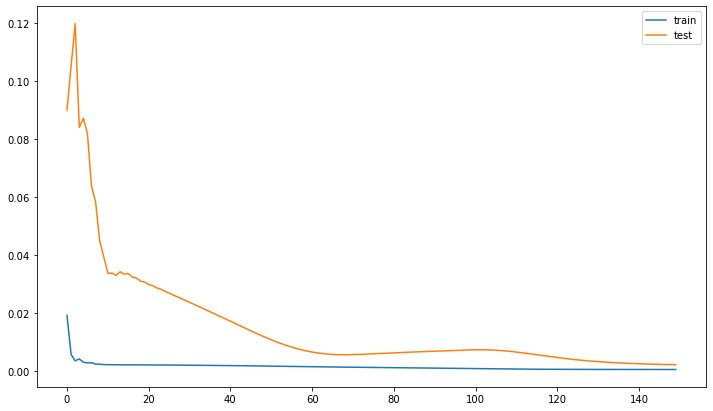

In [18]:
# Model3 : LSTM(50),LSTM(50),LSTM(50),Dense(1)
# design network
model3 = Sequential()
model3.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model3.add(LSTM(50,return_sequences=True))
model3.add(LSTM(50))
model3.add(Dense(1))
model3.compile(loss='mse', optimizer='adam')
# fit network
history3 = model3.fit(X_train, y_train, epochs=150, batch_size=20, validation_data=(X_test, y_test), verbose=1, shuffle=False)
# plot history
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.legend()
plt.show()

2/2 [==============================] - 0s 6ms/step
Test RMSE: 9.825
Forecast RMSE: 37.896


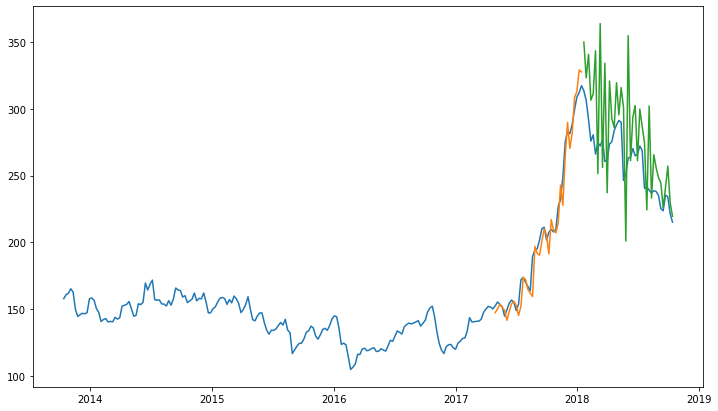

In [19]:
# Make a prediction for validation and forecasting
yhat_test = model3.predict(X_test)
X_test2 = X_test.reshape((X_test.shape[0], X_test.shape[1]))
yhat_forecast = model3.predict(X_forecast)
X_forecast2 = X_forecast.reshape((X_forecast.shape[0], X_forecast.shape[1]))
# invert scaling 
inv_yhat_test = concatenate((yhat_test, X_test2[:, - n_features -1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
inv_yhat_forecast = concatenate((yhat_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_yhat_forecast = scaler.inverse_transform(inv_yhat_forecast)
inv_yhat_forecast = inv_yhat_forecast[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_test = concatenate((y_test, X_test2[:, - n_features -1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]
y_forecast = y_forecast.reshape((len(y_forecast), 1))
inv_y_forecast = concatenate((y_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_y_forecast = scaler.inverse_transform(inv_y_forecast)
inv_y_forecast = inv_y_forecast[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_forecast, inv_yhat_forecast))
print('Forecast RMSE: %.3f' % rmse)
# Plot prediction
df_values=df3.Close
d = {'train': df_values,
     'test': pd.Series(inv_yhat_test, index=df_values.index[np.arange(n_train_weeks+n_weeks,n_train_weeks+n_test_weeks+n_weeks)]),
     'forecast': pd.Series(inv_yhat_forecast, index=df_values.index[np.arange(n_train_weeks+n_test_weeks+n_weeks,len(values)+n_weeks)])
                           }
df_plot=pd.DataFrame(data=d, index=df3.index)
plt.figure();
plt.plot(df_plot);


> Model 4 : 1 LSTM layer (200 units), 1 Dense layer (1 unit)

Epoch 1/150
9/9 [==============================] - 3s 108ms/step - loss: 0.0189 - val_loss: 0.0309
Epoch 2/150
9/9 [==============================] - 0s 22ms/step - loss: 0.0025 - val_loss: 0.0730
Epoch 3/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0031 - val_loss: 0.0446
Epoch 4/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0022 - val_loss: 0.0399
Epoch 5/150
9/9 [==============================] - 0s 18ms/step - loss: 0.0017 - val_loss: 0.0428
Epoch 6/150
9/9 [==============================] - 0s 19ms/step - loss: 0.0019 - val_loss: 0.0310
Epoch 7/150
9/9 [==============================] - 0s 18ms/step - loss: 0.0016 - val_loss: 0.0325
Epoch 8/150
9/9 [==============================] - 0s 16ms/step - loss: 0.0017 - val_loss: 0.0256
Epoch 9/150
9/9 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.0257
Epoch 10/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0016 - val_loss: 0.0221
Epoch 11/150
9/9 [

9/9 [==============================] - 0s 16ms/step - loss: 6.6827e-04 - val_loss: 0.0038
Epoch 83/150
9/9 [==============================] - 0s 15ms/step - loss: 6.6205e-04 - val_loss: 0.0038
Epoch 84/150
9/9 [==============================] - 0s 19ms/step - loss: 6.5613e-04 - val_loss: 0.0037
Epoch 85/150
9/9 [==============================] - 0s 19ms/step - loss: 6.5049e-04 - val_loss: 0.0037
Epoch 86/150
9/9 [==============================] - 0s 19ms/step - loss: 6.4511e-04 - val_loss: 0.0036
Epoch 87/150
9/9 [==============================] - 0s 19ms/step - loss: 6.3996e-04 - val_loss: 0.0036
Epoch 88/150
9/9 [==============================] - 0s 19ms/step - loss: 6.3501e-04 - val_loss: 0.0036
Epoch 89/150
9/9 [==============================] - 0s 19ms/step - loss: 6.3024e-04 - val_loss: 0.0035
Epoch 90/150
9/9 [==============================] - 0s 20ms/step - loss: 6.2562e-04 - val_loss: 0.0035
Epoch 91/150
9/9 [==============================] - 0s 18ms/step - loss: 6.2114e-04 - 

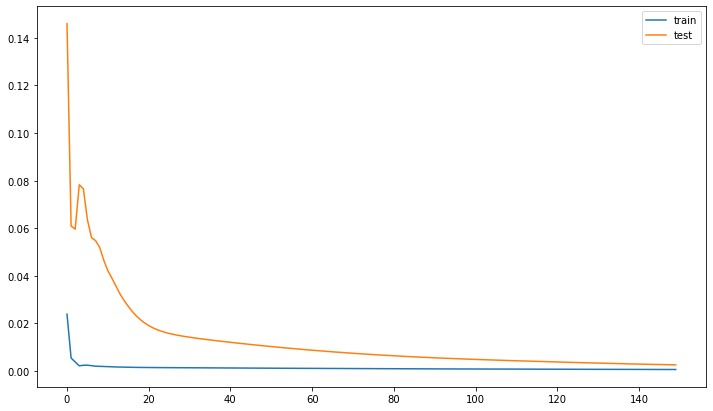

In [20]:
# Model 4: LSTM(200),Dense(1)
# design network
model4 = Sequential()
model4.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model4.add(Dense(1))
model4.compile(loss='mse', optimizer='adam')
# fit network
history4 = model4.fit(X_train, y_train, epochs=150, batch_size=20, validation_data=(X_test, y_test), verbose=1, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

2/2 [==============================] - 0s 6ms/step
Test RMSE: 10.233
Forecast RMSE: 12.404


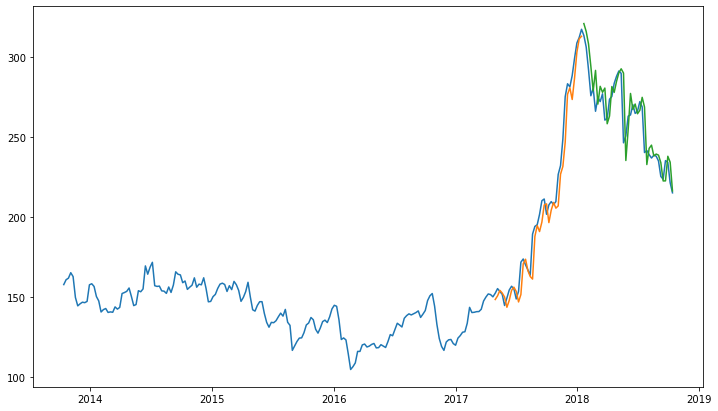

In [21]:
# Make a prediction for validation and forecasting
yhat_test = model4.predict(X_test)
X_test2 = X_test.reshape((X_test.shape[0], X_test.shape[1]))
yhat_forecast = model4.predict(X_forecast)
X_forecast2 = X_forecast.reshape((X_forecast.shape[0], X_forecast.shape[1]))
# invert scaling 
inv_yhat_test = concatenate((yhat_test, X_test2[:, - n_features -1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
inv_yhat_forecast = concatenate((yhat_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_yhat_forecast = scaler.inverse_transform(inv_yhat_forecast)
inv_yhat_forecast = inv_yhat_forecast[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_test = concatenate((y_test, X_test2[:, - n_features -1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]
y_forecast = y_forecast.reshape((len(y_forecast), 1))
inv_y_forecast = concatenate((y_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_y_forecast = scaler.inverse_transform(inv_y_forecast)
inv_y_forecast = inv_y_forecast[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_forecast, inv_yhat_forecast))
print('Forecast RMSE: %.3f' % rmse)
# Plot prediction
df_values=df3.Close
d = {'train': df_values,
     'test': pd.Series(inv_yhat_test, index=df_values.index[np.arange(n_train_weeks+n_weeks,n_train_weeks+n_test_weeks+n_weeks)]),
     'forecast': pd.Series(inv_yhat_forecast, index=df_values.index[np.arange(n_train_weeks+n_test_weeks+n_weeks,len(values)+n_weeks)])
                           }
df_plot=pd.DataFrame(data=d, index=df3.index)
plt.figure();
plt.plot(df_plot);


> Taking Model 1 as our reference, in Models 2 and 3, we added 1 and 2 layers. The fit was optimized in the validation (test) region in orange resulting in slightly better RMSE in this region (not truly significant). 
> However, when looking at the forecast region in green, we see that the results becomes worse when fitting this region with adding more and more layers. Why? One possibility is that when adding layers, the algorithm needs calculating more parameters, which adds more variability in the system resulting in lowering the RMSE in the orange region and not in green region.
>
> Taking Model 1 as reference, in Model 4 the number of units has been increase 4-fold. Both model give similar RMSE.
>
> Taking Model 1 (and 4) as reference, the RMSE is higher than with ARIMA results (10.2-10.6 with LSTM  as opposed to 8.3 with ARIMA).
>
>Be careful, I have noticed that the train and test samples are not the same. This is due to the fact that in our LSTM model, we 'reframed' our dataset because we select a number n_weeks=8.
>
>
>
> The total number of samples is 262. 
In LSTM model, with n_weeks=8, the reframed dataframe shape is 262-n_weeks=254. Out of this 254 sampes, the splitting is train/test/forecast=177/38/39 samples. Hence 8--177/38/39 ->262 samples. The 8 first samples can be considered as part of training samples.
>
> In original ARIMA, the splitting is train/test/untouched=183/39/40 -> 262 samples.
>
>In order to compare ARIMA and LSTM with RMSE, we need to have same training+test samples. Therefore, I will run ARIMA again with the following splitting: 185/38/39. 

Best RMSE: 8.480


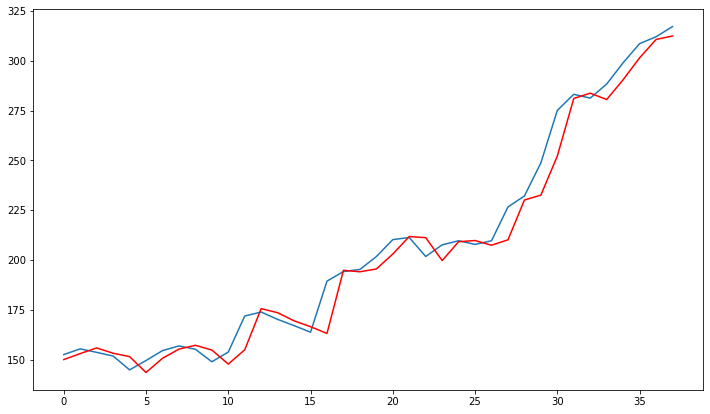

In [22]:
dataset=df3.Close.values # Pay attention to df.ColumnName.values
train, test ,forecast = dataset[0:185], dataset[185:185+38], dataset[185+38:]
# Evaluate with best parameters
rmse,train,test,predictions,model_fit = evaluate_arima_model_test(train,test,forecast, (0, 1, 1))
print('Best RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [23]:
print(len(test))
print(test)

38
[152.52   155.3875 153.63   151.78   144.84   149.52   154.5    156.86
 155.19   148.9125 153.78   171.88   173.88   170.18   167.05   163.75
 189.4    194.2    195.26   201.72   210.24   211.31   201.77   207.6125
 209.68   207.825  209.67   226.64   232.16   248.77   275.12   283.21
 281.28   288.35   299.05   308.625  312.09   317.21  ]


> So, ARIMA still gives slightly better RMSE than LSTM model, at least with the parameters used.
>
> I tried to tune other parameters in LSTM model:
> - increasing Epochs does not improve the results
> - changing batch size from 20 to 10 or 30 yields higher RMSE. 20 was good optimization.
>
> In  the last following cells, I tune n_weeks=4 (also n_weeks=12,16 have been tested and yields similar RMSE, and n_weeks=32 makes it worse)

In [24]:
# Preparing data for LSTM
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Selecting the time series from the initial dataframe --> called 'values' (np.array)
values=df3.values
display(values.shape)
## integer encode direction
##encoder = LabelEncoder()
##values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_weeks = 4
n_features = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_weeks, 1)
print(reframed.head())
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_weeks = int(len(values) * 0.7)
n_test_weeks = int(len(values) * 0.15)
train = values[:n_train_weeks, :]
test = values[n_train_weeks:n_train_weeks+n_test_weeks, :]
forecast = values[n_train_weeks+n_test_weeks:, :]
# split into input and outputs
n_obs = n_weeks * n_features
X_train, y_train = train[:, :n_obs], train[:, -n_features]
X_test, y_test = test[:, :n_obs], test[:, -n_features]
X_forecast, y_forecast = forecast[:, :n_obs], forecast[:, -n_features]
print(X_train.shape, y_train.shape)
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_weeks, n_features))
X_test = X_test.reshape((X_test.shape[0], n_weeks, n_features))
X_forecast = X_forecast.reshape((X_forecast.shape[0], n_weeks, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,X_forecast.shape,y_forecast.shape)

(262, 1)

   var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)
4   0.249576   0.263883   0.268475   0.284529  0.273185
5   0.263883   0.268475   0.284529   0.273185  0.211660
6   0.268475   0.284529   0.273185   0.211660  0.187038
7   0.284529   0.273185   0.211660   0.187038  0.193114
8   0.273185   0.211660   0.187038   0.193114  0.197824
(258, 5)
(180, 4) (180,)
(180, 4, 1) (180,) (38, 4, 1) (38,) (40, 4, 1) (40,)


Epoch 1/150
9/9 [==============================] - 2s 64ms/step - loss: 0.0191 - val_loss: 0.0598
Epoch 2/150
9/9 [==============================] - 0s 15ms/step - loss: 0.0043 - val_loss: 0.0348
Epoch 3/150
9/9 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0605
Epoch 4/150
9/9 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.0443
Epoch 5/150
9/9 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0313
Epoch 6/150
9/9 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0345
Epoch 7/150
9/9 [==============================] - 0s 12ms/step - loss: 0.0016 - val_loss: 0.0284
Epoch 8/150
9/9 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0227
Epoch 9/150
9/9 [==============================] - 0s 13ms/step - loss: 0.0013 - val_loss: 0.0211
Epoch 10/150
9/9 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0172
Epoch 11/150
9/9 [=

9/9 [==============================] - 0s 11ms/step - loss: 7.5345e-04 - val_loss: 0.0043
Epoch 84/150
9/9 [==============================] - 0s 11ms/step - loss: 7.4859e-04 - val_loss: 0.0042
Epoch 85/150
9/9 [==============================] - 0s 10ms/step - loss: 7.4383e-04 - val_loss: 0.0042
Epoch 86/150
9/9 [==============================] - 0s 9ms/step - loss: 7.3916e-04 - val_loss: 0.0041
Epoch 87/150
9/9 [==============================] - 0s 11ms/step - loss: 7.3457e-04 - val_loss: 0.0041
Epoch 88/150
9/9 [==============================] - 0s 11ms/step - loss: 7.3006e-04 - val_loss: 0.0040
Epoch 89/150
9/9 [==============================] - 0s 11ms/step - loss: 7.2563e-04 - val_loss: 0.0040
Epoch 90/150
9/9 [==============================] - 0s 13ms/step - loss: 7.2127e-04 - val_loss: 0.0039
Epoch 91/150
9/9 [==============================] - 0s 10ms/step - loss: 7.1698e-04 - val_loss: 0.0039
Epoch 92/150
9/9 [==============================] - 0s 11ms/step - loss: 7.1275e-04 - v

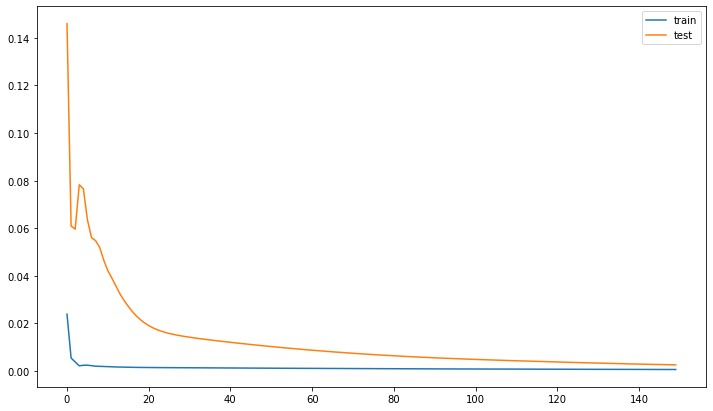

In [25]:
# Model 4: LSTM(200),Dense(1)
# design network
model4 = Sequential()
model4.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model4.add(Dense(1))
model4.compile(loss='mse', optimizer='adam')
# fit network
history4 = model4.fit(X_train, y_train, epochs=150, batch_size=20, validation_data=(X_test, y_test), verbose=1, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

2/2 [==============================] - 0s 5ms/step
Test RMSE: 10.244
Forecast RMSE: 11.683


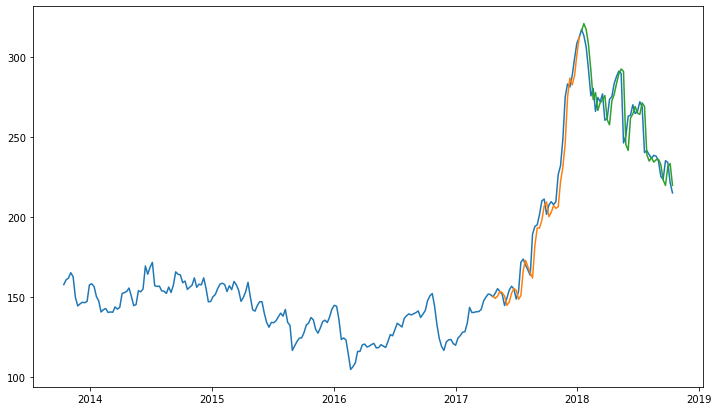

In [26]:
# Make a prediction for validation and forecasting
yhat_test = model4.predict(X_test)
X_test2 = X_test.reshape((X_test.shape[0], X_test.shape[1]))
yhat_forecast = model4.predict(X_forecast)
X_forecast2 = X_forecast.reshape((X_forecast.shape[0], X_forecast.shape[1]))
# invert scaling 
inv_yhat_test = concatenate((yhat_test, X_test2[:, - n_features -1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]
inv_yhat_forecast = concatenate((yhat_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_yhat_forecast = scaler.inverse_transform(inv_yhat_forecast)
inv_yhat_forecast = inv_yhat_forecast[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y_test = concatenate((y_test, X_test2[:, - n_features -1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]
y_forecast = y_forecast.reshape((len(y_forecast), 1))
inv_y_forecast = concatenate((y_forecast, X_forecast2[:, - n_features -1:]), axis=1)
inv_y_forecast = scaler.inverse_transform(inv_y_forecast)
inv_y_forecast = inv_y_forecast[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
print('Test RMSE: %.3f' % rmse)
rmse = sqrt(mean_squared_error(inv_y_forecast, inv_yhat_forecast))
print('Forecast RMSE: %.3f' % rmse)
# Plot prediction
df_values=df3.Close
d = {'train': df_values,
     'test': pd.Series(inv_yhat_test, index=df_values.index[np.arange(n_train_weeks+n_weeks,n_train_weeks+n_test_weeks+n_weeks)]),
     'forecast': pd.Series(inv_yhat_forecast, index=df_values.index[np.arange(n_train_weeks+n_test_weeks+n_weeks,len(values)+n_weeks)])
                           }
df_plot=pd.DataFrame(data=d, index=df3.index)
plt.figure();
plt.plot(df_plot);


<hr style="border-width:2px;border-color:#75DFC1">
<h2 style = "text-align:center"> Conlusions </h2> 
<hr style="border-width:2px;border-color:#75DFC1">

> ARIMA models performed slightly better than LSTM in terms of RMSE, but they are not entirely appropriate models for the time series because the residuals obtained are not white noise and contain ARCH effects.
> It would have been more suitable to model with a combined ARIMA-GARCH model. However such model exist in langage R but no package is in Python.
> 
> LSTMs are doing still very good job.
> Multilayer LSTMs do worse than single layer LSTM. A single-layer LSTM with 50-200 units and epoch>150, batch_size=20 does great.
>
> Fundamental differences between our ARIMA-GD-WFV and our LSTMs models: 
> - In its implementation, ARIMA-GD-WFV needs all training samples for fitting parameters and predict values in the testing range. Therefore, in the forecast region, ARIMA-GD-WFV would need all training+ testing values for making prediction
> - On the other hand, LSTMs has been trained only in the training region. In test region, LSTMs would just need the last n_weeks=8 values of the training range in order to predict the following values. In the forecast region, it would need the last  n_weeks=8 values of the testing range